In [ ]:
%load_ext autoreload
%autoreload 2

# Embeddings

In [ ]:
import nltk
nltk.download('movie_reviews')

In [ ]:
from gensim.models import Word2Vec
from nltk.corpus import movie_reviews

# get sentences from collection
sentences = movie_reviews.sents()
print(len(sentences))

# train model with window 5, 25 dimensions
word_vectors = Word2Vec(sentences, vector_size=25, window=5).wv

In [ ]:
from gensim.models import FastText

model = FastText(vector_size=25, window=5, min_count=1)  # instantiate
model.build_vocab(corpus_iterable=sentences)
model.train(corpus_iterable=sentences, total_examples=len(sentences), epochs=10)
word_vectors = model.wv

In [ ]:
import gensim.downloader

# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

# load a pre-trained glove model
word_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [ ]:
print(word_vectors.get_vector('cat'))
print(word_vectors.most_similar('cat'))
print(word_vectors.most_similar(positive=['paris','germany'], negative=['france']))
paris = word_vectors.get_vector('paris')
germany = word_vectors.get_vector('germany')
france = word_vectors.get_vector('france')
print(word_vectors.similar_by_vector(paris+germany-france))
print(word_vectors.doesnt_match("bird dog cat town".split()))
word_vectors['cat']

In [ ]:
def print_similar(term):
    print(f"{term:>10}: {', '.join([e[0] for e in word_vectors.most_similar(term) if e[1] > 0.7])}")
    print(f"{'':>10}  {', '.join([str(e) for e in word_vectors.get_vector(term)][:7])}, ...")
    print()

def print_analogy(positive, negative):
    left_side = " + ".join(positive) + " - " + " - ".join(negative)
    right_side = ', '.join([e[0] for e in word_vectors.most_similar(positive=positive, negative=negative) if e[1] > 0.1])
    print(f"{left_side:>30} = {right_side}")

def print_doesnt_match(list_of_terms):
    if not list_of_terms is list:
        list_of_terms = list_of_terms.split()
    word = word_vectors.doesnt_match(list_of_terms)
    list_of_terms.remove(word)
    print("{:>10} not in {}".format(word, str(list_of_terms)))

terms = ['woman','movie','cats','nice','vacation']

for t in terms:
    print_similar(t)
print()

print_analogy(['actor','woman'], ['man'])
print_analogy(['paris','germany'], ['france'])
print()

print_doesnt_match("breakfast cereal dinner lunch")
print_doesnt_match("bird dog cat town")
print_doesnt_match("paris berlin frankfurt singapore")
print_doesnt_match("man woman child boy girl")
print_doesnt_match("john peter fred anna")


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gensim.downloader

# get vectors for terms
words = "animal bird dog cat horse fish bee monkey turtle car town train city paris berlin frankfurt singapore man woman child boy girl breakfast cereal dinner lunch".split()
vectors = word_vectors[words]

# apply a PCA to map to 2 dimensions
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# create a scatter plot of the projection
plt.figure(figsize=(14,10))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]-0.05), fontsize=14)
plt.show()

## sentence-transformers/all-MiniLM-L6-v2 [(model homepage)](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

- This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.
- By default, input text longer than 256 word pieces is truncated. 

## sentence-transformers/all-mpnet-base-v2 [(model homepage)](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

- This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.
- By default, input text longer than 384 word pieces is truncated. 


In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 256


In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)


Sentence embeddings:
tensor([[ 6.7657e-02,  6.3496e-02,  4.8713e-02,  7.9305e-02,  3.7448e-02,
          2.6528e-03,  3.9375e-02, -7.0985e-03,  5.9361e-02,  3.1537e-02,
          6.0098e-02, -5.2905e-02,  4.0607e-02, -2.5931e-02,  2.9843e-02,
          1.1269e-03,  7.3515e-02, -5.0382e-02, -1.2239e-01,  2.3703e-02,
          2.9727e-02,  4.2477e-02,  2.5634e-02,  1.9952e-03, -5.6919e-02,
         -2.7160e-02, -3.2904e-02,  6.6025e-02,  1.1901e-01, -4.5879e-02,
         -7.2621e-02, -3.2584e-02,  5.2341e-02,  4.5055e-02,  8.2530e-03,
          3.6702e-02, -1.3942e-02,  6.5392e-02, -2.6427e-02,  2.0638e-04,
         -1.3664e-02, -3.6281e-02, -1.9504e-02, -2.8974e-02,  3.9427e-02,
         -8.8409e-02,  2.6243e-03,  1.3671e-02,  4.8306e-02, -3.1157e-02,
         -1.1733e-01, -5.1169e-02, -8.8529e-02, -2.1896e-02,  1.4299e-02,
          4.4417e-02, -1.3482e-02,  7.4339e-02,  2.6638e-02, -1.9876e-02,
          1.7919e-02, -1.0605e-02, -9.0426e-02,  2.1327e-02,  1.4120e-01,
         -6.4718e

In [3]:
from sentence_transformers import CrossEncoder, SentenceTransformer, util

model_name = 'nq-distilbert-base-v1'
bi_encoder = SentenceTransformer(model_name)

# encode a sentence
vector = bi_encoder.encode('This is a test sentence')
print(len(vector))
print(vector[:10])

768
[ 0.01898636 -0.08441787 -1.0005357   0.15583566 -0.14950188  0.31966394
  1.3621886   0.09708939  0.7396687  -0.0536701 ]


In [4]:
import os, gzip, json

# As dataset, we use Simple English Wikipedia. Compared to the full English wikipedia, it has only
# about 170k articles. We split these articles into paragraphs and encode them with the bi-encoder
filepath = 'data/simplewiki-2020-11-01.jsonl.gz'

if not os.path.exists(filepath):
    util.http_get('http://sbert.net/datasets/simplewiki-2020-11-01.jsonl.gz', filepath)

# extract all paragraphs
paragraphs = []
with gzip.open(filepath, 'rt', encoding='utf8') as f:
    for line in f:
        data = json.loads(line)
        for i, p in enumerate(data['paragraphs']):
            paragraphs.append({'title': data['title'], 'text': p, 'id': f"{data['id']}:{i}"})

print(f'created {len(paragraphs)} paragraphs')

created 509663 paragraphs


length: min=21, max=6628, mean=250


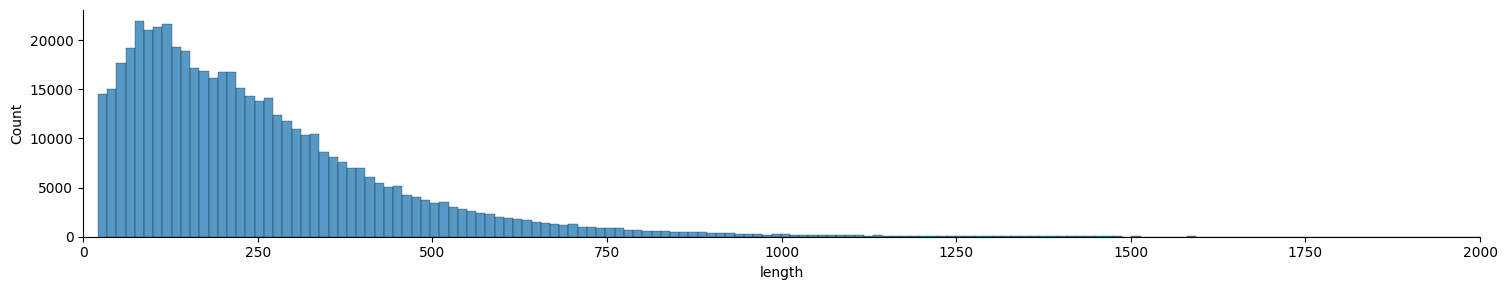

first 5 paragraphs:


[{'title': 'Ted Cassidy',
  'text': 'Ted Cassidy (July 31, 1932 - January 16, 1979) was an American actor. He was best known for his roles as Lurch and Thing on "The Addams Family".',
  'id': '9822:0'},
 {'title': 'Aileen Wuornos',
  'text': 'Aileen Carol Wuornos Pralle (born Aileen Carol Pittman; February 29, 1956\xa0– October 9, 2002) was an American serial killer. She was born in Rochester, Michigan. She confessed to killing six men in Florida and was executed in Florida State Prison by lethal injection for the murders. Wuornos said that the men she killed had raped her or tried to rape her while she was working as a prostitute.',
  'id': '9824:0'},
 {'title': 'Aileen Wuornos',
  'text': 'Wuornos was diagnosed with antisocial personality disorder and borderline personality disorder.',
  'id': '9824:1'},
 {'title': 'Aileen Wuornos',
  'text': 'The movie, "Monster" is about her life. Two documentaries were made about her.',
  'id': '9824:2'},
 {'title': 'Aileen Wuornos',
  'text': 'Wu

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

df = DataFrame([len(p['text']) for p in paragraphs], columns = ['length'])
print(f'length: min={df.length.min():0.0f}, max={df.length.max():0.0f}, mean={df.length.mean():0.0f}')
sns.displot(df, x='length', bins=500, height=3, aspect=5)
plt.xlim(0, 2000)
plt.show()

print(f'first 5 paragraphs:')
paragraphs[0:5]

In [6]:
# building the encodings (unless we alread have them)
filepath = f'data/simplewiki-2020-11-01-{model_name}.pt'

if os.path.exists(filepath):
    embeddings = torch.load(filepath)
else:
    # this can take a while
    embeddings = bi_encoder.encode([p['title'] + ' ' + p['text'] for p in paragraphs], convert_to_tensor=True, show_progress_bar=True)
    torch.save(embeddings, filepath)

embeddings = embeddings.float()
if torch.cuda.is_available():
    embeddings = embeddings.to('cuda')

In [20]:
from transformers import pipeline

qa_model = pipeline("question-answering", model="deepset/roberta-base-squad2")
qa_model(question=["who is the queen", "who is the queen", "who is the queen"], context=["I am the king, but she is the queen", "I was the king", "Peter is the king"])



[{'score': 0.004178143572062254,
  'start': 19,
  'end': 35,
  'answer': 'she is the queen'},
 {'score': 9.64819491855451e-07, 'start': 10, 'end': 14, 'answer': 'king'},
 {'score': 1.44779889410529e-07,
  'start': 0,
  'end': 17,
  'answer': 'Peter is the king'}]

In [13]:
from transformers import pipeline

def text_from_hit(hit):
    p = paragraphs[hit['corpus_id']]
    return p['title']+': '+p['text']

def create_prompt(query, context):
    return " ".join([
        "Synthesize a comprehensive answer from the following context for the given question.",
        "Provide a clear and concise response that summarizes the key points and information presented in the text.",
        "Your answer should be in your own words and be no longer than 50 words.",
        "If you don't know the answer, then say so.",
        "Question: " + query,
        "Context: " + context
    ])


# perform semantic search
queries = [
    "Apple iPhone",
    "Which product is better: iPhone or Samsung?"
    "When is the flight from Zurich to London?",
    "For what did Albert Einstein win the Nobelprize?", 
    "What is the Capital of France?", 
    "Who invented the iPhone?", 
    "What does Rhodes Statue look like?", 
    "Who won the FIFA World Cup 2018?", 
    "Who were the members of the Beatles band?", 
    "Who was Gandhi?", 
    "What does relativity mean?"
]
q_vectors = bi_encoder.encode(queries, convert_to_tensor=True)
hits = util.semantic_search(q_vectors, embeddings, top_k=100)

# use this model for cross-encoder re-ranking
model = CrossEncoder('cross-encoder/stsb-distilroberta-base')

# use this model to provide answers
qa_model = pipeline("question-answering", model="deepset/roberta-base-squad2")

# uset his model to generate a textual answer
answer_generator = pipeline("text2text-generation", model="google/flan-t5-base")

for i in range(len(queries)):
    # print query
    print(f"Query: {queries[i]}")
    # print bi-encoder results
    for hit in hits[i][0:5]:
        print(f"\tbi-encoder\t{hit['score']:.3f}\t{paragraphs[hit['corpus_id']]}")
    # re-rank with cross-encoder
    combinations = [[queries[i], text_from_hit(hit)] for hit in hits[i]]
    cross_scores = model.predict(combinations)
    # get indexes of top-k results
    for j in cross_scores.argsort()[-5:][::-1]:
        print(f"\tcross-encoder\t{cross_scores[j]:.3f}\t{paragraphs[hits[i][j]['corpus_id']]}")
    # build context from retrieved paragraphs
    context = " ".join([text_from_hit(hit) for hit in hits[i]])
    ans = qa_model(question=queries[i], context=context, top_k=3)
    answers = ";   ".join([a['answer'] for a in ans])
    print(f"\treader\t\t\t{answers}")
    # generate textual answer
    text = answer_generator(queries[i], max_length=100)
    print(f"\ttext2text-q\t\t{text[0]['generated_text']}")
    prompt = create_prompt(queries[i], context)
    text = answer_generator(prompt, max_length=100)
    print(f"\ttext2text-p\t\t{text[0]['generated_text']}")
    print("\tprompt\t\t\t" + prompt)
    print("\n\n========\n")


Query: Apple iPhone
	bi-encoder	0.553	{'title': 'Apple Inc.', 'text': 'There are several different types of iPods:', 'id': '7111:4'}
	bi-encoder	0.538	{'title': 'Apple Inc.', 'text': 'The iPhone is a mobile phone that can make calls, send text messages, play games and music, show photos and videos (like an iPod), browse the Internet, and do much more. It was one of the first smartphones in the world when the first version was announced in 2007. Apple usually makes and sells a different model every year, with new models being faster and more powerful and having a newer version of iOS than those that come before them. The newest iPhones released are the iPhone 11 and the iPhone 11 Pro which run on iOS 13. Many cellular carriers around the world sell iPhones, including Sprint, Verizon, AT&T, and T-Mobile in the US.', 'id': '7111:10'}
	bi-encoder	0.517	{'title': 'Mac OS', 'text': '"For the Apple computer family, see macOS"', 'id': '516:0'}
	bi-encoder	0.487	{'title': 'IOS', 'text': 'iOS (p

Token indices sequence length is longer than the specified maximum sequence length for this model (4859 > 512). Running this sequence through the model will result in indexing errors


	text2text-q		Apple iPhone - iPhone XS
	text2text-p		The iPhone is a mobile phone that can make calls, send text messages, play games and music, show photos and videos (like an iPod), browse the Internet, and do much more.
	prompt			Synthesize a comprehensive answer from the following context for the given question. Provide a clear and concise response that summarizes the key points and information presented in the text. Your answer should be in your own words and be no longer than 50 words. If you don't know the answer, then say so. Question: Apple iPhone Context: Apple Inc.: There are several different types of iPods: Apple Inc.: The iPhone is a mobile phone that can make calls, send text messages, play games and music, show photos and videos (like an iPod), browse the Internet, and do much more. It was one of the first smartphones in the world when the first version was announced in 2007. Apple usually makes and sells a different model every year, with new models being faster and mo

KeyboardInterrupt: 

## spaCy

In [ ]:
import spacy 

nlp = spacy.load('en_core_web_lg')
tokens = nlp("this is a sentence. this is another sentence.")
tokens.vector